In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *
from src.layers import *

## Data

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='train',
    tp_log=1,
    pure_sr_ratio=8
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


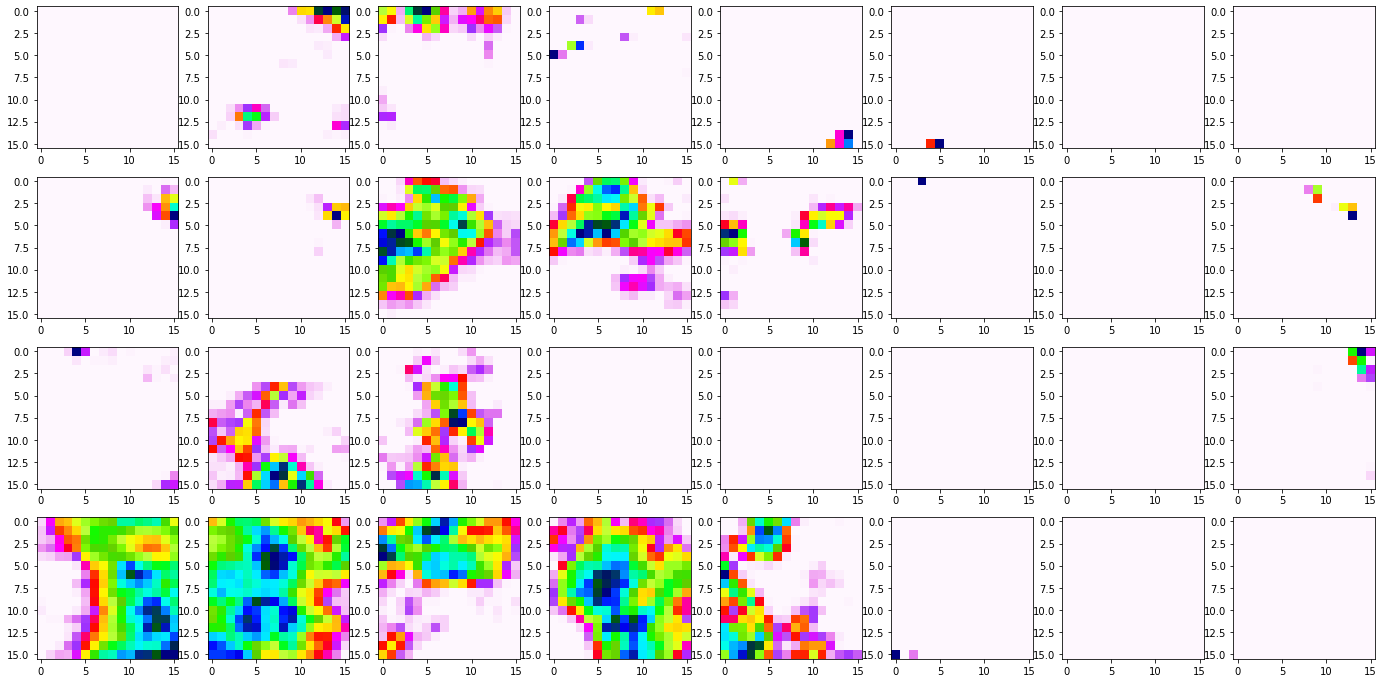

In [7]:
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for i, ax in enumerate(axs.flat):
    X, y = ds_train[i+62]
    ax.imshow(X[0], cmap='gist_ncar_r')

In [8]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='valid',
    tp_log=1,
    pure_sr_ratio=8
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [9]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [10]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, sampler=sampler_valid)

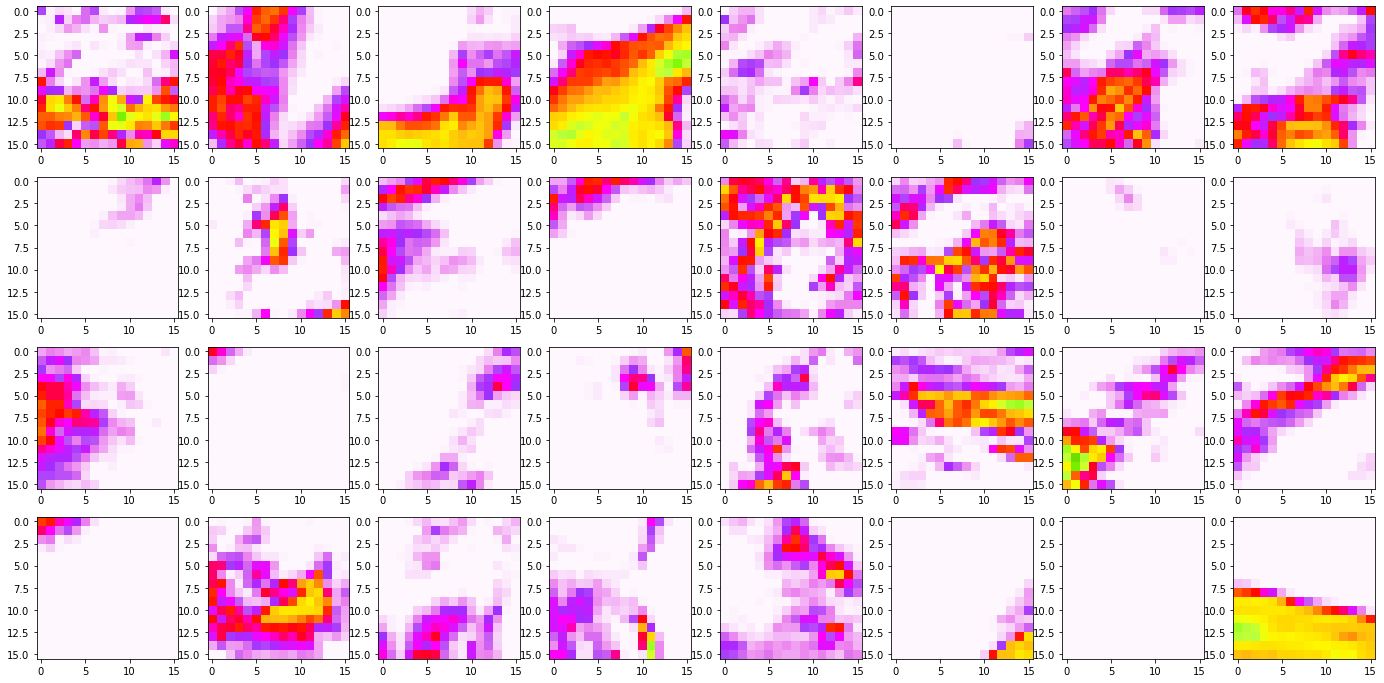

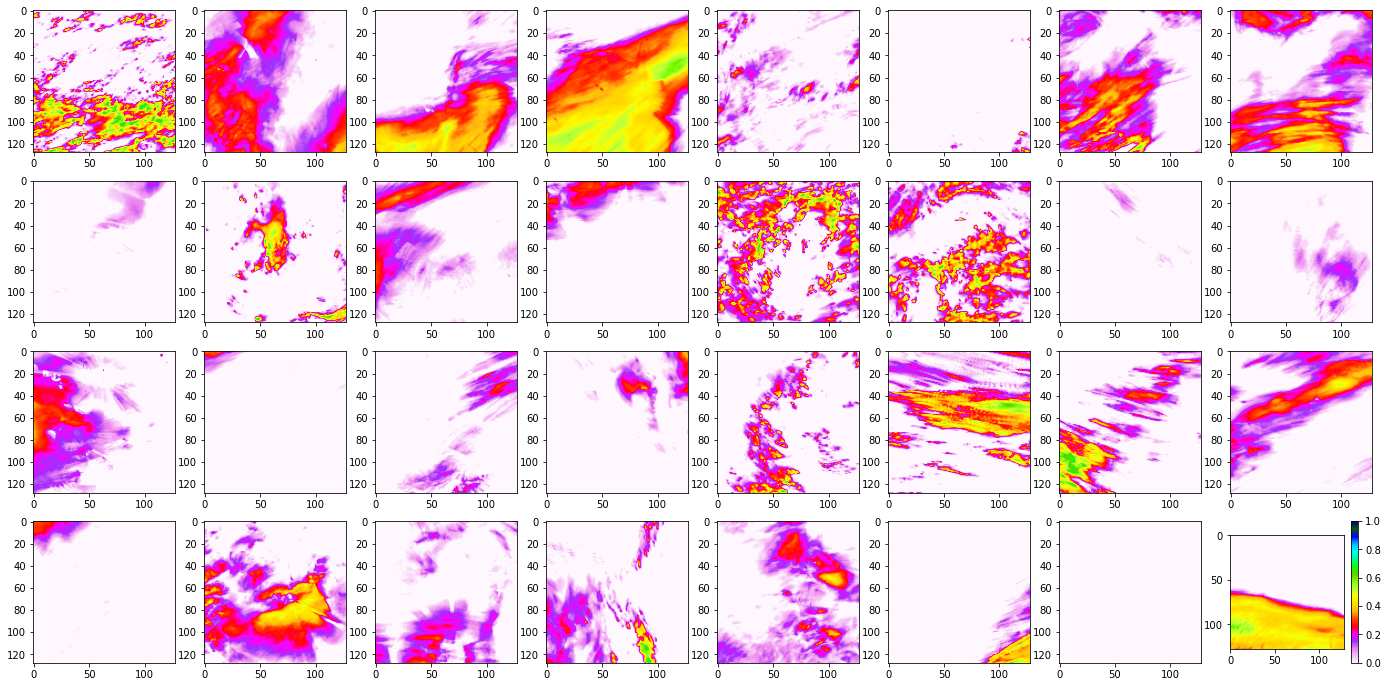

In [11]:
X, Y = next(iter(dl_train))
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for x, ax in zip(X.numpy(), axs.flat):
    ax.imshow(x[0], cmap='gist_ncar_r', vmin=0, vmax=1)
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for y, ax in zip(Y.numpy(), axs.flat):
    I = ax.imshow(y[0], cmap='gist_ncar_r', vmin=0, vmax=1)
plt.colorbar(I, ax=axs.flatten()[-1])

In [12]:
# Distribution without weighting
mean_precip = []
for idx in range(len(ds_train.idxs)):
    X, y = ds_train.__getitem__(idx, no_cat=True)
    mean_precip.append(y.mean())
# Distribution after weighting
mean_precip2 = []
for X, y in dl_train:
    mean_precip2.extend(y.mean((1, 2, 3)).numpy())

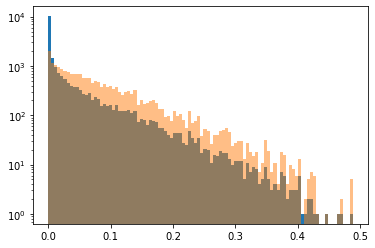

In [13]:
plt.hist(mean_precip, bins=100);
plt.hist(mean_precip2, bins=100, alpha=0.5);
plt.yscale('log')

In [14]:
len(ds_train), len(dl_train)

(20988, 656)

In [15]:
X, y = ds_train[0]

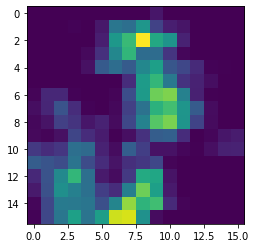

In [16]:
plt.imshow(X[0])

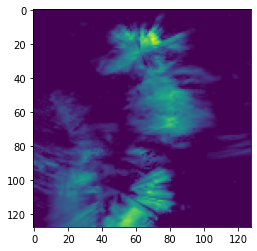

In [17]:
plt.imshow(y[0])

## Leinonen-like architecture

In [18]:
gen = Generator(
    nres=3, nf_in=1, nf=256, use_noise=True, spectral_norm=True
).to(device)

In [19]:
disc = Discriminator(
    nf=256, ndown=4, nres=3, sigmoid=False, spectral_norm=True
).to(device)

In [20]:
count_parameters(gen)/1e6, count_parameters(disc)/1e6

(4.167607, 4.789025)

In [21]:
betas = (0.5, 0.9)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-4, betas=betas)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=betas)

In [28]:
X_sample, y_sample = next(iter(dl_train))

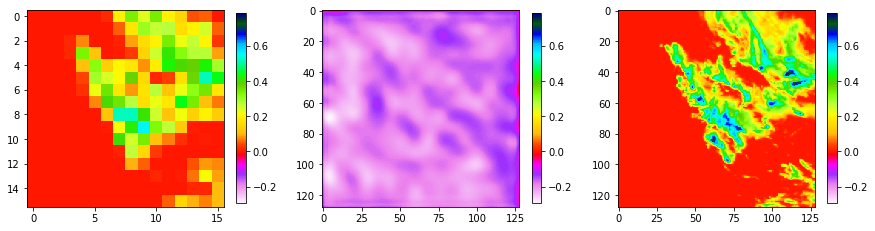

In [29]:
plot_sample(X_sample, y_sample, gen, 0)

## Pretraining

In [30]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [31]:
trainer = Trainer(gen, optimizer, criterion, dl_train, dl_valid)

In [32]:
trainer.fit(1)

In [33]:
# torch.save(gen.state_dict(), f'gen_pretrained_sn.pt')
# gen.load_state_dict(torch.load('gen_pretrained.pt'))

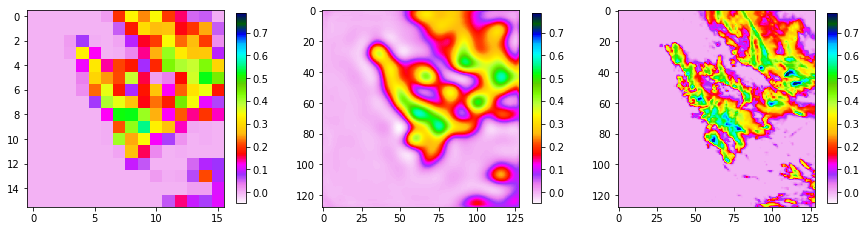

In [34]:
plot_sample(X_sample, y_sample, gen, 0)

## GAN

In [35]:
trainer = GANTrainer(
    gen, disc, gen_optimizer, disc_optimizer, dl_train, disc_repeats=5, l_loss='l1', 
    adv_loss_type='Wasserstein', gp_lambda=10,
    l_lambda=5, plot=True, plotting_sample=(X_sample, y_sample)
)

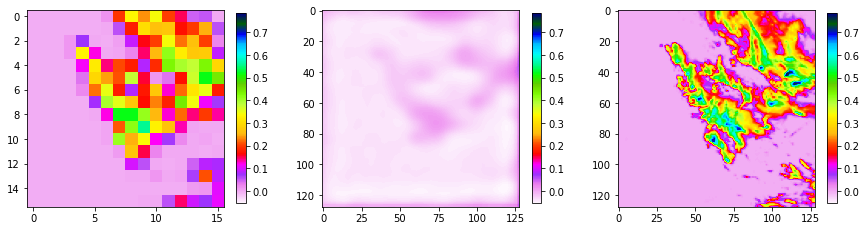

KeyboardInterrupt: 

In [36]:
trainer.fit(10)

Text(0.5, 1.0, 'Disc loss')

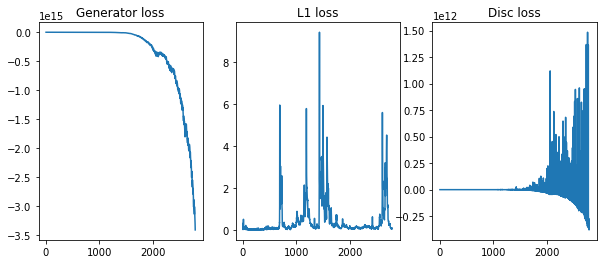

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.plot(trainer.train_gen_losses); ax1.set_title('Generator loss')
ax2.plot(trainer.train_l_losses); ax2.set_title('L1 loss')
ax3.plot(trainer.train_disc_losses); ax3.set_title('Disc loss')

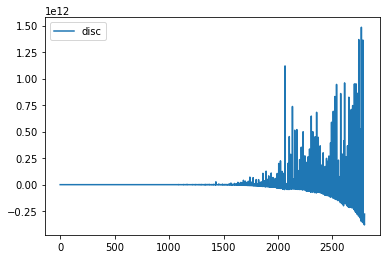

In [38]:
# plt.plot(trainer.train_gen_losses, label='gen')
# plt.plot(trainer.train_l_losses, label='l_loss')
plt.plot(trainer.train_disc_losses, label='disc')
plt.legend()

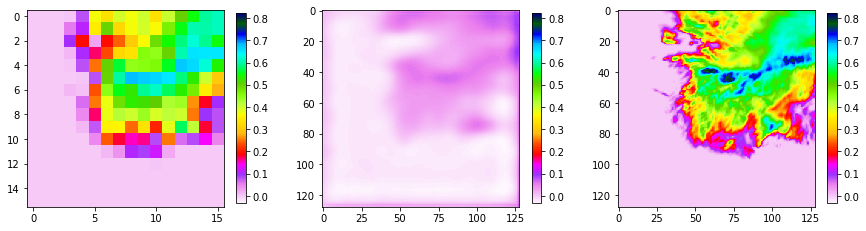

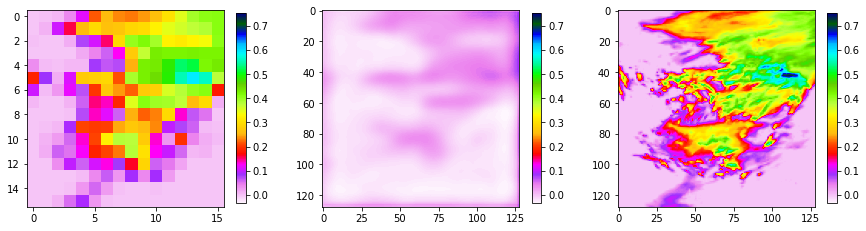

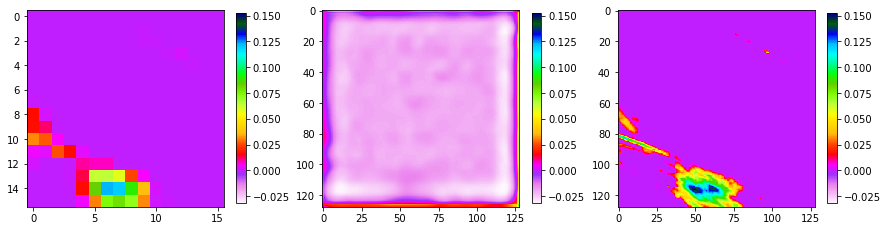

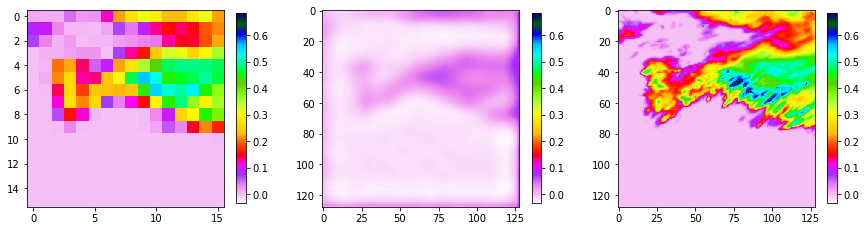

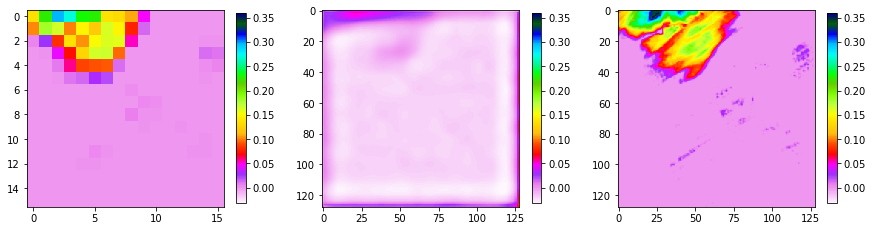

In [38]:
X, y = next(iter(dl_train))
for i in range(5):
    plot_sample(X, y, gen, i)

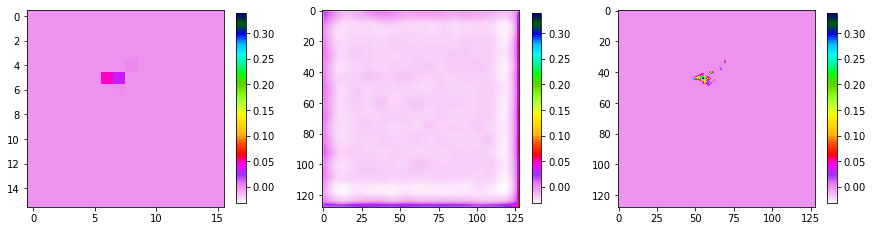

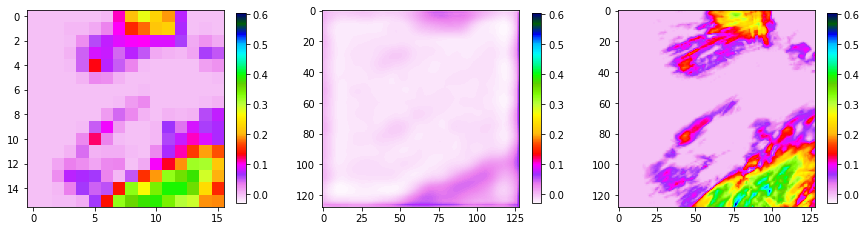

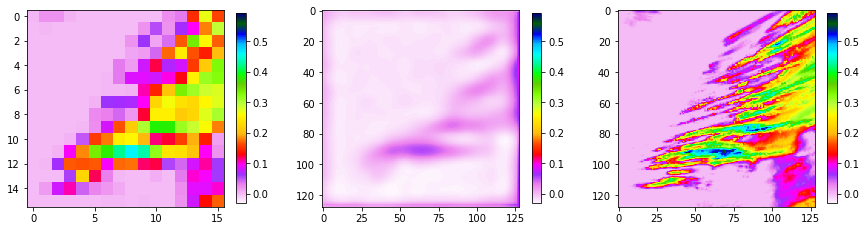

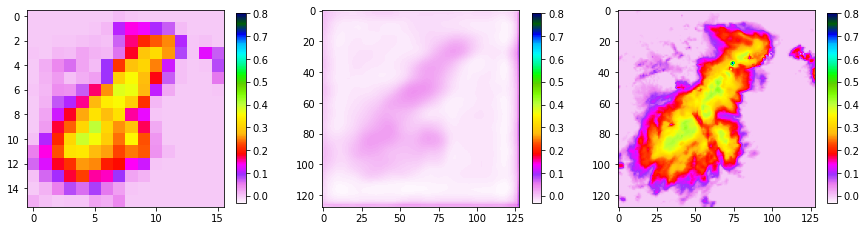

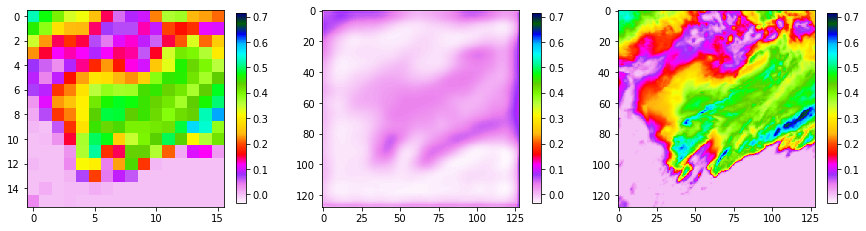

In [39]:
X, y = next(iter(dl_valid))
for i in range(5):
    plot_sample(X, y, gen, i)

(array([13.,  7.,  4.,  3.,  2.,  1.,  0.,  0.,  0.,  2.]),
 array([3.1134609e+10, 3.1134636e+10, 3.1134663e+10, 3.1134689e+10,
        3.1134716e+10, 3.1134745e+10, 3.1134771e+10, 3.1134798e+10,
        3.1134824e+10, 3.1134851e+10, 3.1134878e+10], dtype=float32),
 <BarContainer object of 10 artists>)

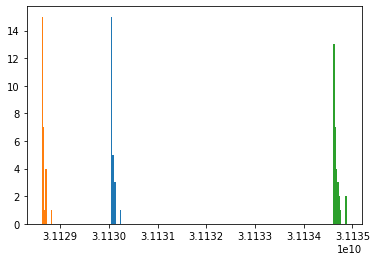

In [37]:
plt.hist(trainer.disc_preds_real[-1])
plt.hist(trainer.disc_preds_fake[-1])
plt.hist(trainer.gen_preds_fake[-1])

In [42]:
import pickle

In [43]:
with open('10.trainer', 'wb') as f:
    pickle.dump(trainer, f)

## Sanity check

- Just train G with large l_lambda works as expected --> probably not a data thing then
- Lower learning rate 1e-4 --> 1e-5 (and no pretraining) --> 

In [52]:
gen = Generator(
    nres=3, nf_in=1, nf=256, use_noise=True, spectral_norm=True
).to(device)

In [53]:
disc = Discriminator(
    nf=256, ndown=4, nres=3, sigmoid=False, spectral_norm=True
).to(device)

In [54]:
count_parameters(gen)/1e6, count_parameters(disc)/1e6

(4.167607, 4.789025)

In [55]:
betas = (0.5, 0.9)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-5, betas=betas)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-5, betas=betas)

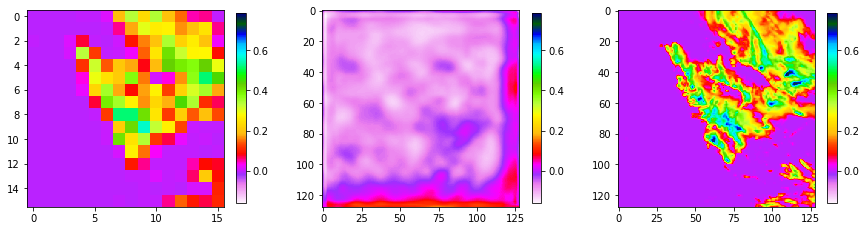

In [56]:
plot_sample(X_sample, y_sample, gen, 0)

In [57]:
trainer = GANTrainer(
    gen, disc, gen_optimizer, disc_optimizer, dl_train, disc_repeats=5, l_loss='l1', 
    adv_loss_type='Wasserstein', gp_lambda=10,
    l_lambda=5, plot=True, plotting_sample=(X_sample, y_sample)
)

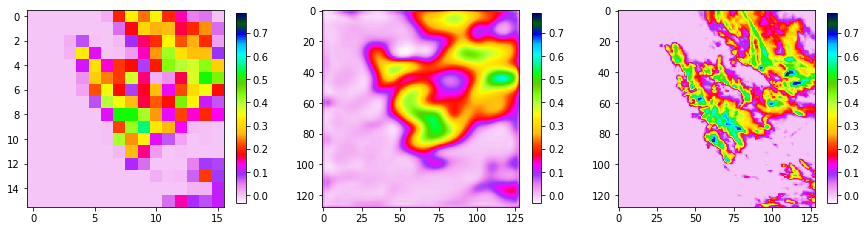

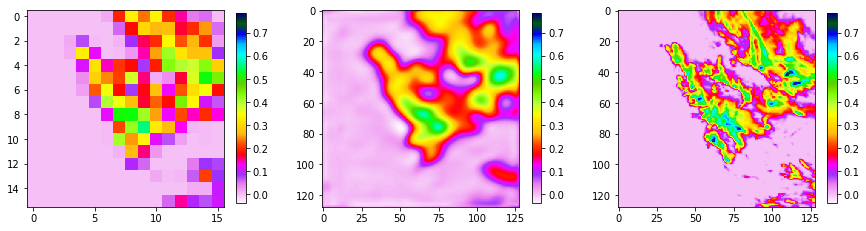

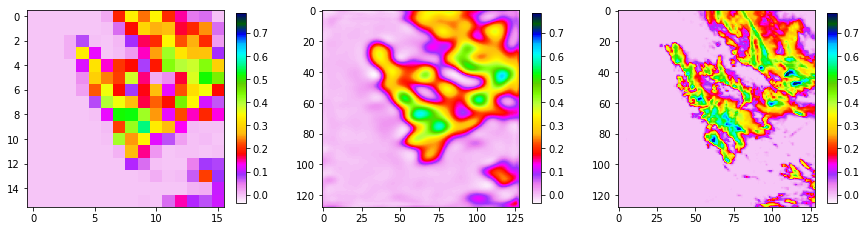

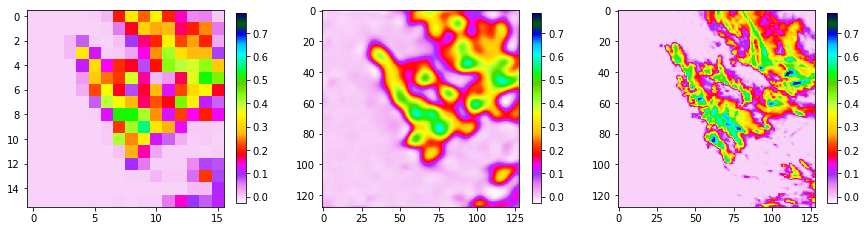

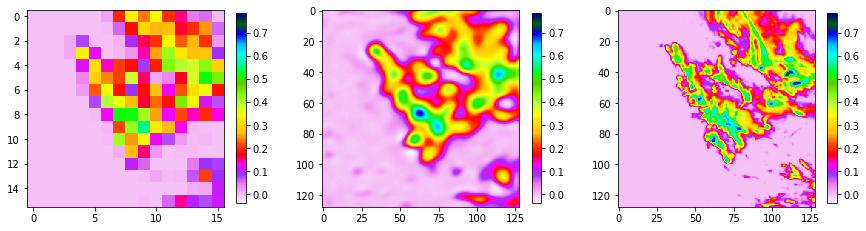

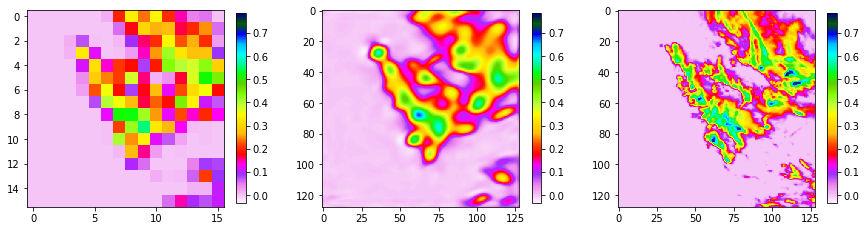

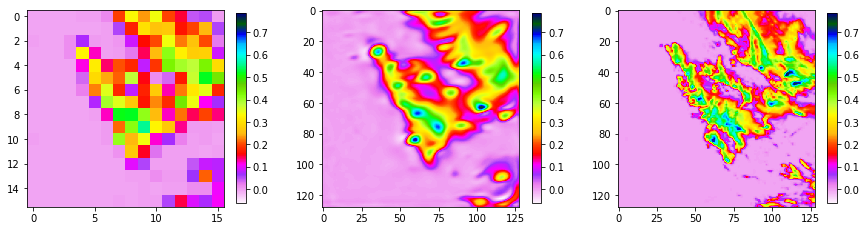

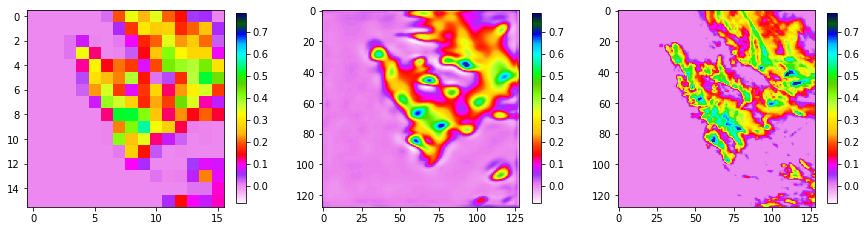

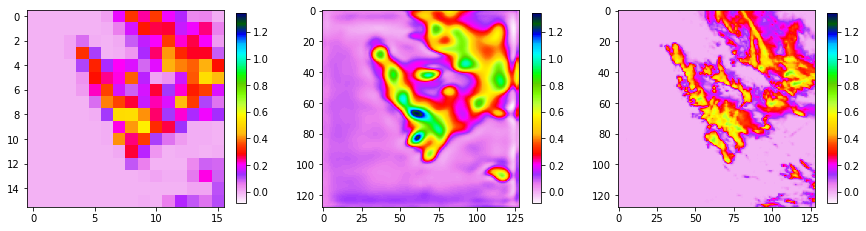

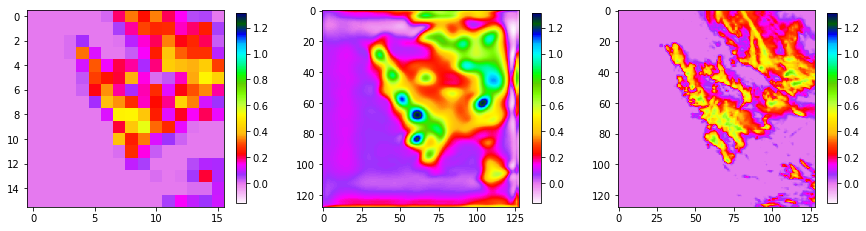

In [58]:
trainer.fit(10)